In [ ]:
!pip install lime

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    print("LIME library not found. Please run '!pip install lime' and restart the runtime.")
    LIME_AVAILABLE = False

warnings.filterwarnings('ignore')

In [ ]:
print("--- Step 1: Loading & Preprocessing Heart Disease Data ---")


df = pd.read_csv('synthetic_heart_disease_dataset.csv')



df = df.sample(n=5000, random_state=42)


categorical_cols = [
    'Gender', 'Smoking', 'Alcohol_Intake',
    'Physical_Activity', 'Diet', 'Stress_Level'
]


le_dict = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le


target_col = 'Heart_Disease'
X = df.drop(columns=[target_col])
y = df[target_col]
feature_names = X.columns.tolist()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

print(f"Data Prepared: {len(X_train)} training samples, {len(X_test)} test samples.")

--- Step 1: Loading & Preprocessing Heart Disease Data ---
Data Prepared: 4500 training samples, 500 test samples.


In [ ]:
print("\n--- Step 2: Distributing Data to Clients ---")


client_data = []
num_clients = 3
chunk_size = len(X_train) // num_clients

for i in range(num_clients):
    start = i * chunk_size

    end = (i + 1) * chunk_size if i != num_clients - 1 else len(X_train)

    X_c = X_train[start:end]
    y_c = y_train[start:end]
    client_data.append((X_c, y_c))
    print(f"   Client {i+1}: Received {len(X_c)} patient records.")


--- Step 2: Distributing Data to Clients ---
   Client 1: Received 1500 patient records.
   Client 2: Received 1500 patient records.
   Client 3: Received 1500 patient records.


In [ ]:
# 1. Lightweight Additive Encryption (The Paper's Logic: c = w + k)
def encrypt_weights(coef, intercept, noise_scale=0.01):

    mask_coef = np.random.normal(0, noise_scale, coef.shape)
    mask_intercept = np.random.normal(0, noise_scale, intercept.shape)


    encrypted_coef = coef + mask_coef
    encrypted_intercept = intercept + mask_intercept

    return encrypted_coef, encrypted_intercept, mask_coef, mask_intercept


# 2. Corrected Wrapper for Scikit-Learn compatibility with LIME
class FederatedModelWrapper:
    def __init__(self, coef, intercept, classes):
        self.coef_ = coef
        self.intercept_ = intercept
        self.classes_ = classes

    def predict_proba(self, X):

        z = np.dot(X, self.coef_.T) + self.intercept_



        if self.coef_.shape[0] == 1:

            p1 = 1 / (1 + np.exp(-z))
            p0 = 1 - p1
            return np.hstack([p0, p1])
        else:

            exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def predict(self, X):
        probs = self.predict_proba(X)

        return self.classes_[np.argmax(probs, axis=1)]
        return np.argmax(probs, axis=1)

In [ ]:
print("\n--- Step 3: Starting Federated Learning Rounds (FL + HE) ---")


encrypted_coefs_list = []
encrypted_intercepts_list = []
masks_coef_list = []
masks_intercept_list = []


for client_id, (X_c, y_c) in enumerate(client_data):

    local_model = LogisticRegression(max_iter=200)
    local_model.fit(X_c, y_c)


    enc_coef, enc_int, mask_c, mask_i = encrypt_weights(local_model.coef_, local_model.intercept_)


    encrypted_coefs_list.append(enc_coef)
    encrypted_intercepts_list.append(enc_int)
    masks_coef_list.append(mask_c)
    masks_intercept_list.append(mask_i)

    print(f"   Client {client_id+1}: Training Complete -> Weights Encrypted -> Sent to Server.")


--- Step 3: Starting Federated Learning Rounds (FL + HE) ---
   Client 1: Training Complete -> Weights Encrypted -> Sent to Server.
   Client 2: Training Complete -> Weights Encrypted -> Sent to Server.
   Client 3: Training Complete -> Weights Encrypted -> Sent to Server.


In [ ]:
print("\n--- Step 4: Server Aggregation & Decryption ---")


avg_encrypted_coef = np.mean(encrypted_coefs_list, axis=0)
avg_encrypted_intercept = np.mean(encrypted_intercepts_list, axis=0)


avg_mask_coef = np.mean(masks_coef_list, axis=0)
avg_mask_intercept = np.mean(masks_intercept_list, axis=0)

global_coef = avg_encrypted_coef - avg_mask_coef
global_intercept = avg_encrypted_intercept - avg_mask_intercept


unique_classes = np.unique(y)
final_model = FederatedModelWrapper(global_coef, global_intercept, unique_classes)


y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"   Global Model Aggregated successfully.")
print(f"   Final Accuracy on Test Set: {acc:.2f}")


--- Step 4: Server Aggregation & Decryption ---
   Global Model Aggregated successfully.
   Final Accuracy on Test Set: 0.92



--- Step 5: Generating Key Visualizations ---


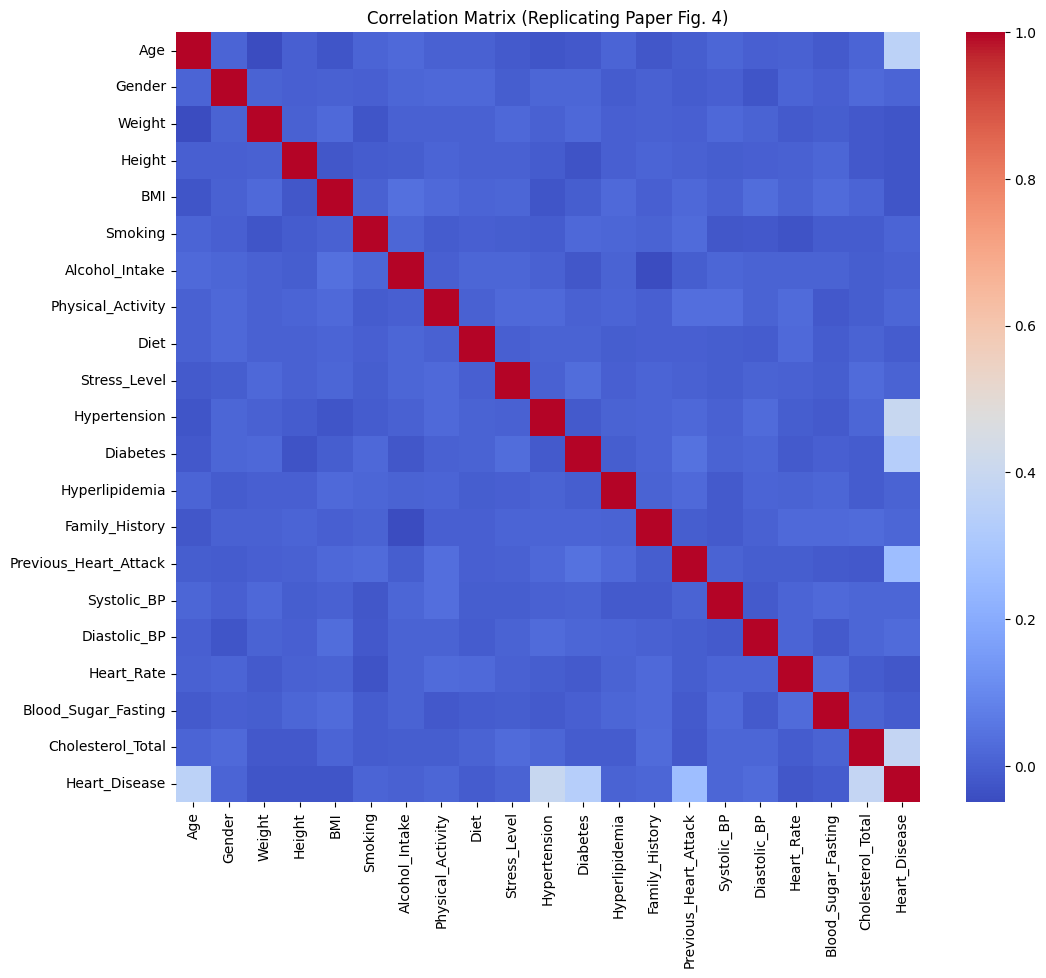

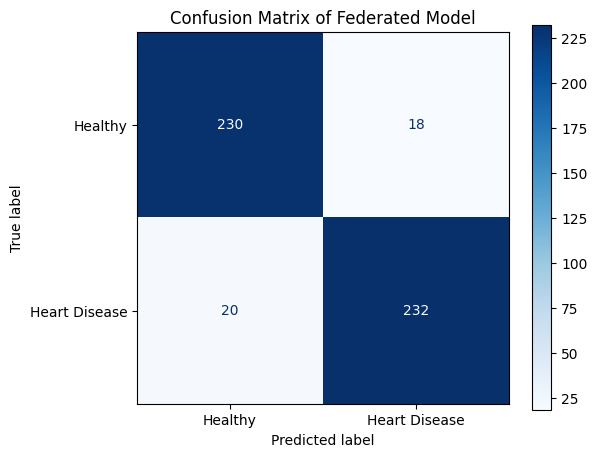

In [ ]:
print("\n--- Step 5: Generating Key Visualizations ---")

# Graph A: Correlation Matrix (Matches Fig 4 in Paper)
plt.figure(figsize=(12, 10))

sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix (Replicating Paper Fig. 4)")
plt.show()

# Graph B: Confusion Matrix (Proof of Performance)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Heart Disease"])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix of Federated Model")
plt.show()

In [ ]:
print("\n--- Step 6: Applying XAI (LIME) at Conclusion ---")

if LIME_AVAILABLE:

    patient_idx = 8
    patient_data = X_test[patient_idx]
    true_label_code = y_test.iloc[patient_idx]
    true_label_text = "Heart Disease" if true_label_code == 1 else "Healthy"

    print(f"   Explaining prediction for Patient #{patient_idx}")
    print(f"   Actual Condition: {true_label_text}")


    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=["Healthy", "Heart Disease"],
        mode='classification'
    )


    exp = explainer.explain_instance(
        data_row=patient_data,
        predict_fn=final_model.predict_proba
    )


    try:
        exp.show_in_notebook(show_table=True)
    except:
        print("   Could not display notebook widget. Printing text explanation:")
        for feature, weight in exp.as_list():
            print(f"   {feature}: {weight:.4f}")
else:
    print("   LIME is not installed. Skipping XAI step.")


--- Step 6: Applying XAI (LIME) at Conclusion ---
   Explaining prediction for Patient #8
   Actual Condition: Healthy
